In [1]:

import ICE.Data
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils

import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset_loader import CSVDatasetWithName
import torch
import numpy as np
import shutil
import os
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np

In [16]:
###not to run
#images_path = '../data/HAM10000/ISIC2018_Task3_Training_Input/'
#csv_path = '../data/csv_splits/isic2018f_train.csv'
#model_path = '../models/iv4_isic2018_t3/checkpoints/model_best.pth'

In [3]:
#images_path = '../../isic-data/HAM10000/ISIC2018_Task3_Training_Input/'
images_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/'
csv_path = 'isic2018_T1T2_results_complete.csv'
model_path = '../../DL-Models-ISIC/results-comet-iv4/rn50_i18nf_5runs_5/checkpoints/model_best.pth'


In [4]:
df=pd.read_csv(csv_path)
images =df.image.values
labels = df.Label_true.values

In [5]:
df['image'] = df['image'].astype(str) +'.jpg'

In [6]:
id2label = {0:'Benign',1:'Melanoma'}

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
idx=0
benign_df=df.loc[((df['Label_true']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]
ben_df=benign_df.sample(n=78,random_state=0)
idx=1
mel_df=df.loc[((df['Label_true']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]

final_df_list=[ben_df,mel_df]
final_df = pd.concat(final_df_list)
final_df = final_df.rename(columns={'Label_true': 'label'})
lala=final_df.image.values

In [9]:
lala

array(['ISIC_0002488.jpg', 'ISIC_0014581.jpg', 'ISIC_0013738.jpg',
       'ISIC_0000421.jpg', 'ISIC_0010588.jpg', 'ISIC_0000496.jpg',
       'ISIC_0000081.jpg', 'ISIC_0000352.jpg', 'ISIC_0000433.jpg',
       'ISIC_0016052.jpg', 'ISIC_0011373.jpg', 'ISIC_0001871.jpg',
       'ISIC_0012475.jpg', 'ISIC_0010562.jpg', 'ISIC_0014923.jpg',
       'ISIC_0013325.jpg', 'ISIC_0013238.jpg', 'ISIC_0015202.jpg',
       'ISIC_0014394.jpg', 'ISIC_0014453.jpg', 'ISIC_0010178.jpg',
       'ISIC_0015009.jpg', 'ISIC_0015985.jpg', 'ISIC_0012223.jpg',
       'ISIC_0013235.jpg', 'ISIC_0013094.jpg', 'ISIC_0015641.jpg',
       'ISIC_0000047.jpg', 'ISIC_0000486.jpg', 'ISIC_0000388.jpg',
       'ISIC_0015223.jpg', 'ISIC_0000189.jpg', 'ISIC_0002975.jpg',
       'ISIC_0014765.jpg', 'ISIC_0011328.jpg', 'ISIC_0015973.jpg',
       'ISIC_0000418.jpg', 'ISIC_0016046.jpg', 'ISIC_0012212.jpg',
       'ISIC_0004715.jpg', 'ISIC_0000357.jpg', 'ISIC_0002246.jpg',
       'ISIC_0000538.jpg', 'ISIC_0014992.jpg', 'ISIC_0012803.j

In [10]:


def make_imgs(paths = [],labels = []):
    imgs = []
    for i,path in enumerate(paths):
        imgs += [(os.path.join(images_path,path),labels[0])]
    
    return imgs

def get_loaders(df,target_classes = []):
    loaders = []
    for i,idx in enumerate(target_classes):
        loaders.append(DataLoader(
                ICE.Data.ImageDataset(make_imgs(df.loc[((df['label']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]['image'],[idx]),
                      transform = preprocess),
                batch_size = 64,
                num_workers=1,))
    return loaders


def get_explainer(paras,model,df,high_res):
    classes_names = paras['classes_names']
    target_classes = paras['target_classes']
    n_components = paras['n_components']
    layer_name = paras['layer_name'] 
    title = paras['title']
    overwrite = paras['overwrite']

    if overwrite:
        try:
            shutil.rmtree('Explainers/'+title)
        except:
            pass

    model.set_predict_target(target_classes)
    loaders = get_loaders(df,target_classes)
    if os.path.exists(Path('Explainers')/title):
        Exp = ICE.Explainer.Explainer(title = title)
        Exp.load()
        print ('model loaded')
    else:

    # create an Explainer
        Exp = ICE.Explainer.Explainer(title = title,
                        layer_name = layer_name,
                        class_names = classes_names,
                        utils = ICE.utils.img_utils(mode = "torch"),
                        n_components = n_components,
                        reducer_type = "NMF", 
                        high_res=high_res
                      )

        # train reducer based on target classes
        Exp.train_model(model,loaders)
        # generate features 
        Exp.generate_features(model, loaders)
        # generate global explanations
        Exp.global_explanations()
        # save the explainer, use load to load it with the same title
        Exp.save()

    return Exp

m = torch.load(model_path)
m = m.cuda()
m.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Global Explanations

In [11]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'layer4'
paras['title'] = "n2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=64,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(16,17):
    paras['n_components'] = nc
    paras['title'] = "test_hr_rn50_78b_skin2class_concepts_64batchmodel"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp_hr = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp_hr)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : layer4
title : test_hr_rn50_78b_skin2class_concepts_64batchmodel16
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 7, 7, 2048)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 18.882441520690918 s.
3/5 Error estimated, fidelity: [0.09977497 0.15647346].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([29, 20, 59, 24,  8]), array([ 97, 148, 155, 125, 142]), array([43, 30,  7, 33, 45]), array([ 86, 111,  98, 117, 139]), array([110, 100, 119, 101, 149]), array([29, 64, 59, 36, 72]), array([17,  4, 15, 35, 50]), array([15, 41, 39,  0, 19]), array([135,  81,  92,  94, 133]), array([27, 41, 42, 43, 33]), array([31, 13, 21, 48, 33]), array([17, 40, 26, 16, 24]), array([39,  0, 41, 32, 11]), array([56,  9, 19, 23, 38]), array([127, 154, 123, 143, 122]), array([124, 140,  99,  79,  85])]
Generate explanations with fullset condition
Number of componensts:  16, fidelity error: [0.09977497 0.15647346], a

In [12]:
from PIL import Image
size_high_res=(2048,1536)


def get_attr_imgs_row(Exp,idx):
    feature_path = Exp.exp_location / Exp.title / "feature_imgs/"
    idx_list =Exp.feat_samples_index_list[idx]
    x_list=[]
    for i in idx_list:
        img = Image.open(Exp.masked_imgs_path+Exp.class_images_names[i][:-4]+'_attributes.jpg')
        img=img.resize(size_high_res)
        x_list.append(img)
        
    x_list = np.hstack(x_list)
    imgs_comb = Image.fromarray(x_list)
    imgs_comb.save(str(feature_path)+'c'+str(idx)+'.jpg' )
    
for i in range(0,16):
    get_attr_imgs_row(Exp_hr,i)

In [25]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'layer4'
paras['title'] = "n2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=64,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(16,17):
    paras['n_components'] = nc
    paras['title'] = "lr_rn50_78b_skin2class_concepts_64batch_model"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=False)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : layer4
title : lr_rn50_78b_skin2class_concepts_64batch_model16
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 7, 7, 2048)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 68.53936767578125 s.
3/5 Error estimated, fidelity: [0.09977497 0.15647346].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([29, 20, 59, 24,  8]), array([ 97, 148, 155, 125, 142]), array([43, 30,  7, 33, 45]), array([ 86, 111,  98, 117, 139]), array([110, 100, 119, 101, 149]), array([29, 64, 59, 36, 72]), array([17,  4, 15, 35, 50]), array([15, 41, 39,  0, 19]), array([135,  81,  92,  94, 133]), array([27, 41, 42, 43, 33]), array([31, 13, 21, 48, 33]), array([17, 40, 26, 16, 24]), array([39,  0, 41, 32, 11]), array([56,  9, 19, 23, 38]), array([127, 154, 123, 143, 122]), array([124, 140,  99,  79,  85])]
Generate explanations with fullset condition
Number of componensts:  16, fidelity error: [0.09977497 0.15647346], av

## Local Explanations

In [29]:
## 
from PIL import Image
imag_array = ['ISIC_0015109.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((224,224))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp.local_explanations(x,model,name=imag[:-4])
    Exp_hr.local_explanations(x,model,name=imag[:-4])
    

Prediction [-1.4592967  2.4114861]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Prediction [-1.4592967  2.4114861]
Folder exists


In [31]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 5
paras['layer_name'] = 'layer4'
paras['title'] = "ice_rn50_5_concepts_312ben_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list_s=[]

for nc in range(10,17):
    paras['n_components'] = nc
    paras['title'] = "small_312b_ice_rn50_concepts_"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
        
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=False)
    Explainers_list_s.append(Exp)

for expl in Explainers_list_s:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 10
layer_name : layer4
title : small_312b_ice_rn50_concepts_10
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (390, 10, 10, 2048)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 17.324719667434692 s.
3/5 Error estimated, fidelity: [0.08466546 0.84680215].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([19,  2, 56, 38, 23]), array([42, 32, 33,  0, 41]), array([364, 327, 356, 353, 357]), array([39, 23, 30, 33, 45]), array([25, 19, 35, 50, 15]), array([ 8, 38, 91, 36, 29]), array([33, 54, 48, 43, 13]), array([ 6, 38, 23, 19, 39]), array([11, 16, 59, 24,  8]), array([18, 16,  1, 21, 31])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 11
layer_name : layer4
title : small_312b_ice_rn50_concepts_11
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (390, 10, 10, 2048)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 22.73370361328125 s.
3/5 Error estimated, fidelity: [0.0831465  0.92167633].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([19,  2, 56, 38, 23]), array([42, 32, 33,  0, 41]), array([364, 327, 356, 353, 357]), array([ 7, 23, 30, 33, 45]), array([25, 19, 35, 50, 15]), array([36,  3,  8, 29, 55]), array([33, 54, 48, 43, 13]), array([ 6, 23, 38, 39, 19]), array([16, 20, 59, 24,  8]), array([40, 16,  1, 21, 31]), array([32, 39, 41,  0, 11])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 12
layer_name : layer4
title : small_312b_ice_rn50_concepts_12
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (390, 10, 10, 2048)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 33.436007022857666 s.
3/5 Error estimated, fidelity: [0.07647345 0.81217615].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([19,  2, 56, 38, 23]), array([33, 19, 32, 41,  0]), array([328, 327, 356, 353, 357]), array([ 7, 23, 33, 30, 45]), array([25, 19, 35, 50, 15]), array([ 3, 36,  8, 55, 29]), array([33, 54, 48, 43, 13]), array([ 9, 23, 38, 19, 39]), array([16, 20, 59, 24,  8]), array([ 1, 62, 16, 40, 31]), array([32, 39, 41,  0, 11]), array([ 1, 27, 50, 18, 33])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 13
layer_name : layer4
title : small_312b_ice_rn50_concepts_13
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of 

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 32.602135181427 s.
3/5 Error estimated, fidelity: [0.07551108 0.86755923].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([12,  2, 56, 23, 38]), array([39, 19, 32, 41,  0]), array([388, 327, 356, 353, 357]), array([40, 23, 33, 30, 45]), array([35, 50, 25, 19, 15]), array([ 3, 38,  8, 55, 29]), array([33, 54, 48, 43, 13]), array([ 9, 19, 38, 23, 39]), array([16, 20, 59, 24,  8]), array([10,  1, 16, 40, 31]), array([32, 39, 41,  0, 11]), array([42, 41, 27, 18, 33]), array([53, 18, 17, 35, 50])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 14
layer_name : layer4
title : small_312b_ice_rn50_concepts_14
overwrite : True
Training reducer:
1/5 Featuer maps gathere

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 33.575531244277954 s.
3/5 Error estimated, fidelity: [0.07539716 0.8820575 ].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([12,  2, 56, 38, 23]), array([41, 15, 19, 32,  0]), array([388, 327, 356, 353, 357]), array([40, 23, 33, 30, 45]), array([35, 50, 25, 19, 15]), array([36, 38,  8, 55, 29]), array([33, 54, 48, 43, 13]), array([ 9, 23, 38, 19, 39]), array([16, 20, 59, 24,  8]), array([10, 16,  1, 40, 31]), array([32, 39, 41,  0, 11]), array([ 1, 33, 50, 15, 18]), array([21, 18, 17, 35, 50]), array([39, 43, 27, 41, 33])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 15
layer_name : layer4
title : small_312b_ice_rn50_concepts_15
overwrite : True
Tr

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 17.93798279762268 s.
3/5 Error estimated, fidelity: [0.07148729 0.92394574].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([12,  2, 56, 23, 38]), array([19, 15, 41, 32,  0]), array([364, 327, 356, 353, 357]), array([40, 23, 33, 30, 45]), array([35, 19, 50, 25, 15]), array([ 3, 36,  8, 55, 29]), array([33, 54, 48, 43, 13]), array([42, 39, 41,  0, 19]), array([23,  9, 24, 38,  6]), array([62,  1, 16, 40, 31]), array([32, 39, 41,  0, 11]), array([32, 20, 24, 59,  8]), array([21, 18, 17, 35, 50]), array([27, 41, 23, 39, 33]), array([33,  1, 50, 15, 18])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : layer4
title : small_312b_ice_

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 27.022697925567627 s.
3/5 Error estimated, fidelity: [0.06851456 0.94604181].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([16,  2, 56, 23, 38]), array([51, 40, 41, 32,  0]), array([364, 327, 356, 353, 357]), array([ 7,  2, 40, 30, 45]), array([50, 43, 45, 25, 15]), array([47,  3, 29,  8, 55]), array([33, 54, 48, 43, 13]), array([42,  0, 15, 41, 19]), array([ 9, 60, 24, 38,  6]), array([10, 16,  1, 40, 31]), array([32, 39, 41,  0, 11]), array([32, 20, 59, 24,  8]), array([21, 14, 17, 50, 35]), array([41, 31, 23, 39, 33]), array([56, 33, 23, 15, 38]), array([33,  1, 15, 50, 18])]
Generate explanations with fullset condition
Number of componensts:  10, fidelity error: [0.08466546 0.84680215], average : 0.46573380563253

target_classes : [1]
classes_names : ['melanoma']
n_components : 5
layer_name : features
title : melanoma_5_concepts
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (78, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 6.102980613708496 s.
3/5 Error estimated, fidelity: [0.1941697].
4/5 Weight estimator initialized.
5/5 Weight estimated.
--r featuretopk 5
--r imgTopk 5
---r featureIdx [0, 1, 2, 3, 4]
--r featureidx [0, 1, 2, 3, 4]
visulizing features:
[0, 1, 2, 3, 4]
loading training data
batches 2


No------------------------------	 0
[42  0  1 58 16]
[[42, 0, 1, 58, 16], [], [], [], []]


No------------------------------	 1
[54 50 56 52 30]
[[42, 0, 1, 58, 16], [54, 50, 56, 52, 30], [], [], []]


No------------------------------	 2
[ 2 19 29 39 31]
[[42, 0, 1, 58, 16], [54, 50, 56, 52, 30], [2, 19, 29, 39, 31], [], []]


No------------------------------	 3
[ 8 10  4 21 55]
[[42, 0, 1, 58, 16], [54, 50, 56, 52, 30], [2, 19, 29, 39, 31], [8, 10, 4, 21, 55], []]


No------------------------------	 4
[14 17 44 11 16]
[[42, 0, 1, 58, 16], [54, 50, 56, 52, 30], [2, 19, 29, 39, 31], [8, 10, 4, 21, 55], [14, 17, 44, 11, 16]]


No------------------------------	 0
[0 6 5 9 7]
new i

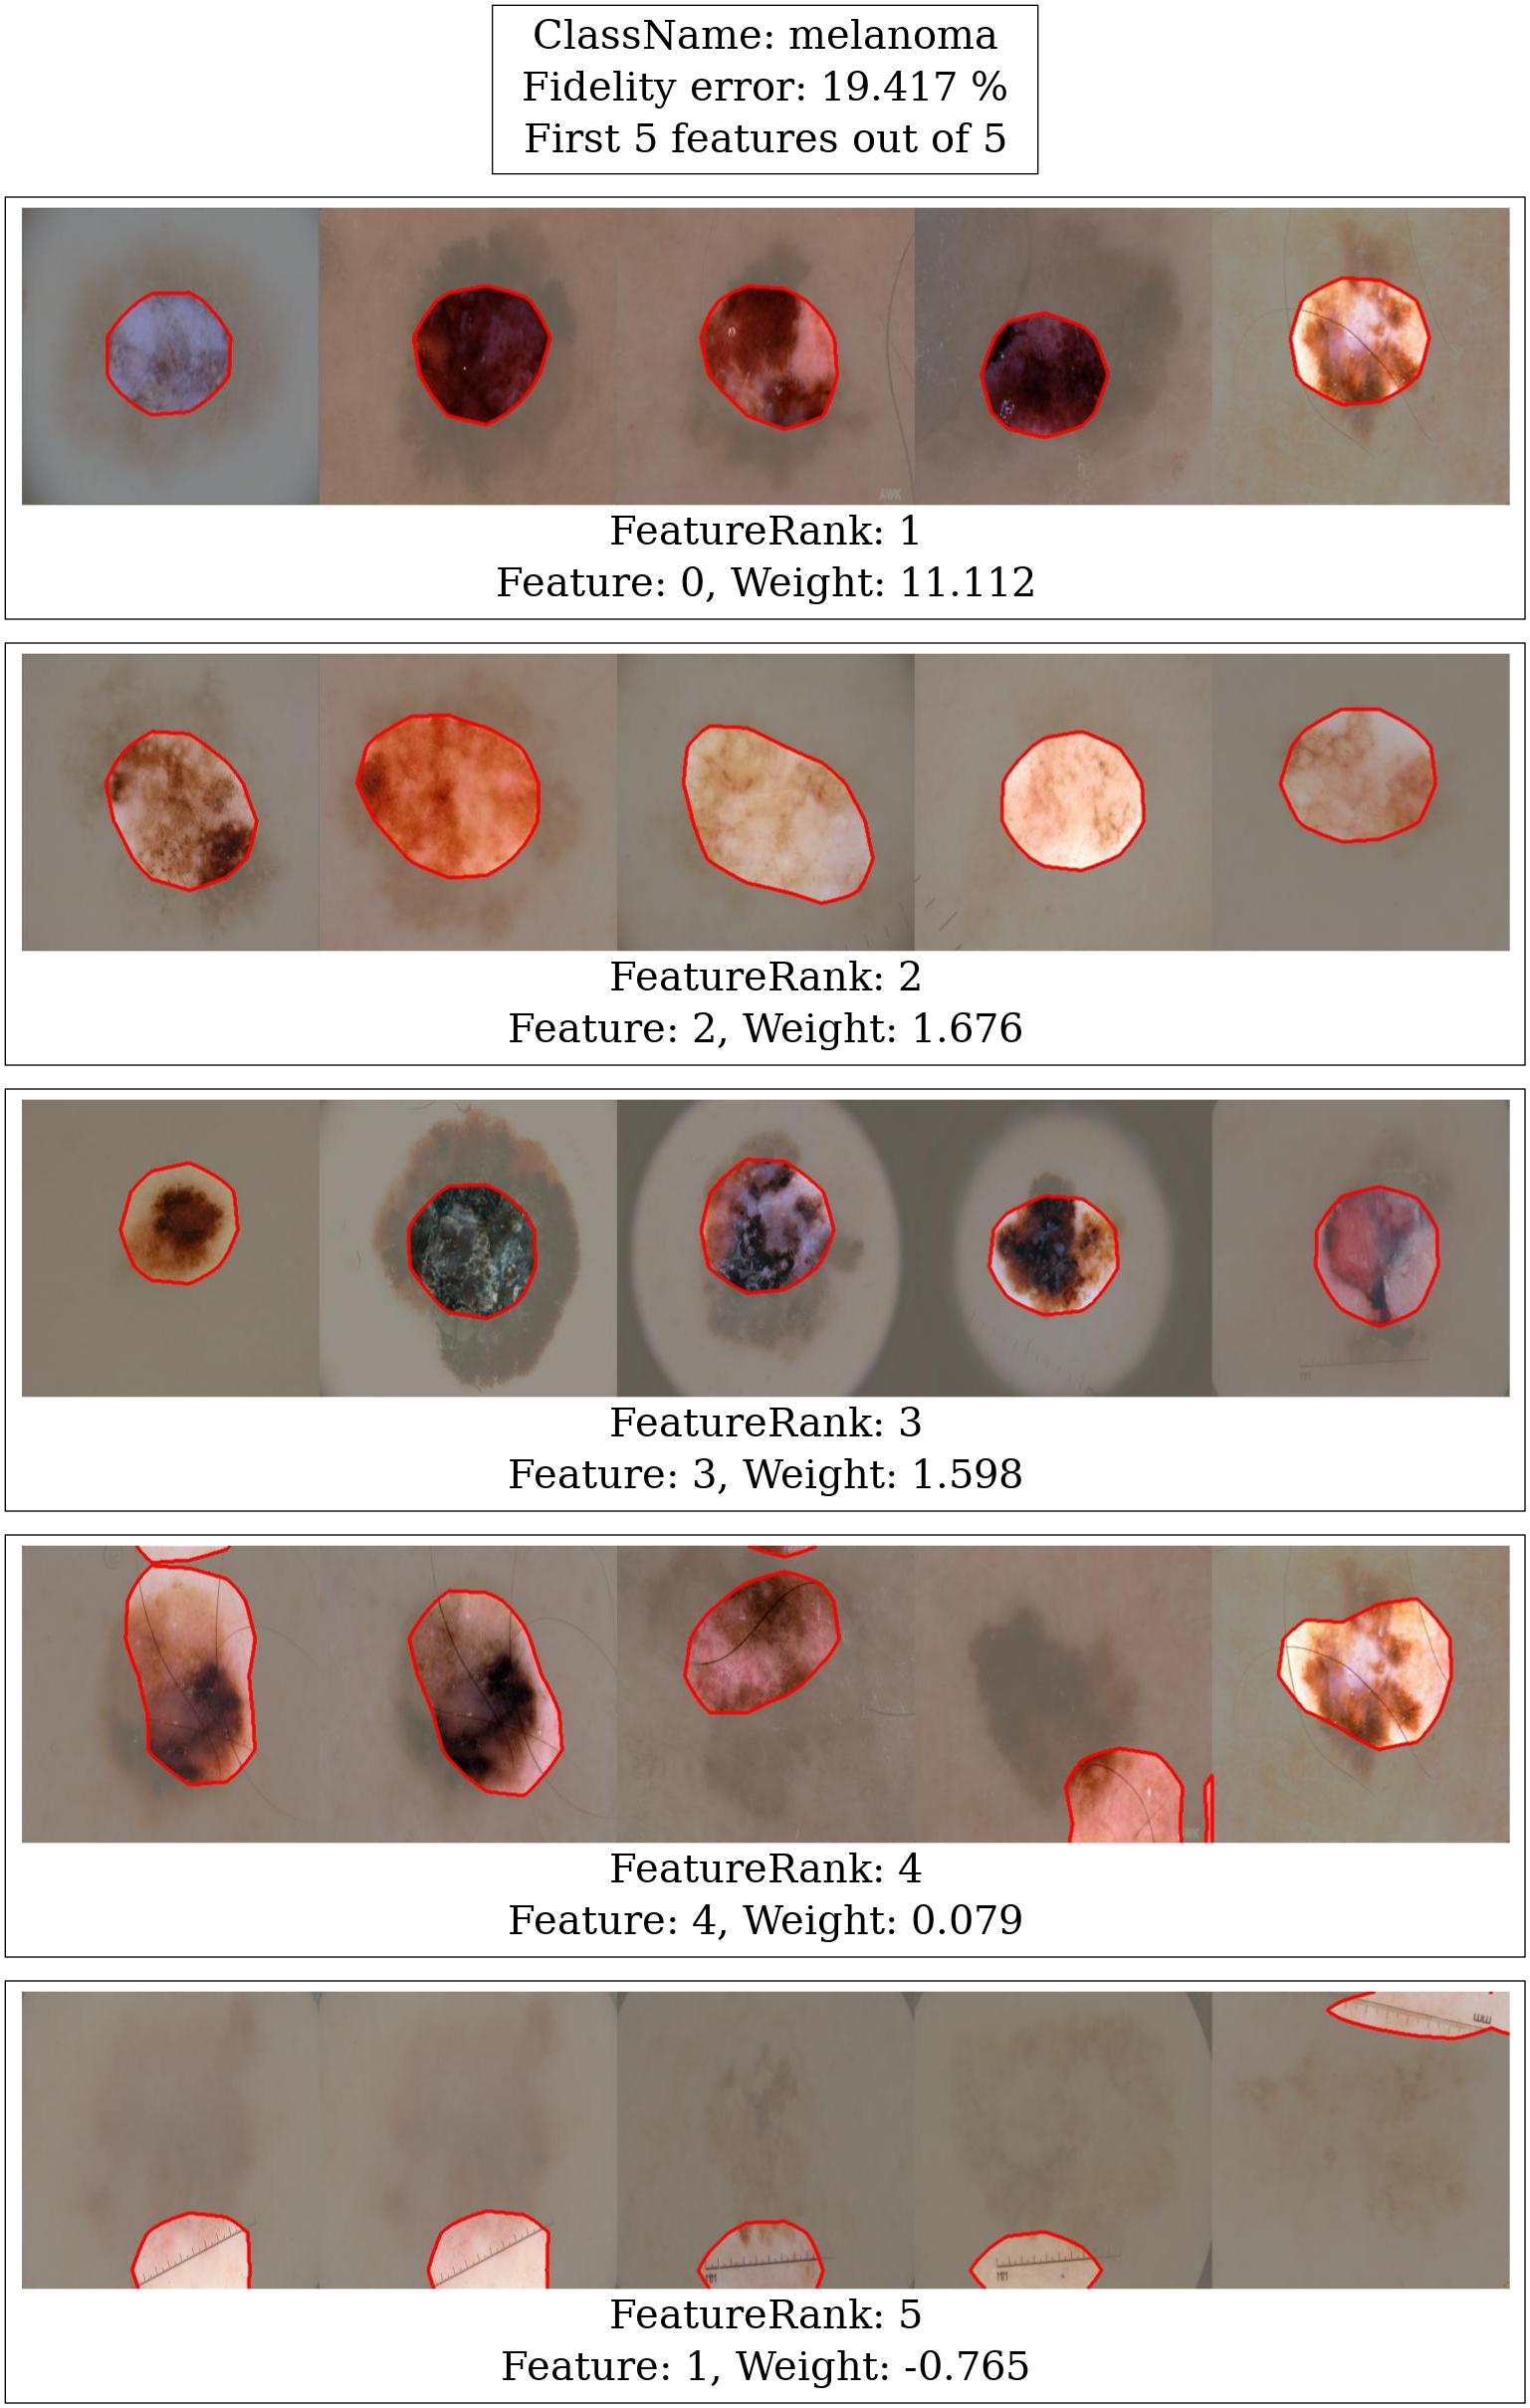

In [12]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 5
paras['layer_name'] = 'features'
paras['title'] = "melanoma_5_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

target_classes : [1]
classes_names : ['melanoma']
n_components : 15
layer_name : features
title : melanoma_15_concepts
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (78, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 17.99504256248474 s.
3/5 Error estimated, fidelity: [0.16802215].
4/5 Weight estimator initialized.
5/5 Weight estimated.
--r featuretopk 15
--r imgTopk 5
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
--r featureidx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data
batches 2


No------------------------------	 0
[ 6  3 58  0 16]
[[6, 3, 58, 0, 16], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


No------------------------------	 1
[54 50 56 52 30]
[[6, 3, 58, 0, 16], [54, 50, 56, 52, 30], [], [], [], [], [], [], [], [], [], [], [], [], []]


No------------------------------	 2
[49  9  2 32 19]
[[6, 3, 58, 0, 16], [54, 50, 56, 52, 30], [49, 9, 2, 32, 19], [], [], [], [], [], [], [], [], [], [], [], []]


No------------------------------	 3
[26 55 21 34  8]
[[6, 3, 58, 0, 16], [54, 50, 56, 52, 30], [49, 9, 2, 32, 19], [26, 55, 21, 34, 8]

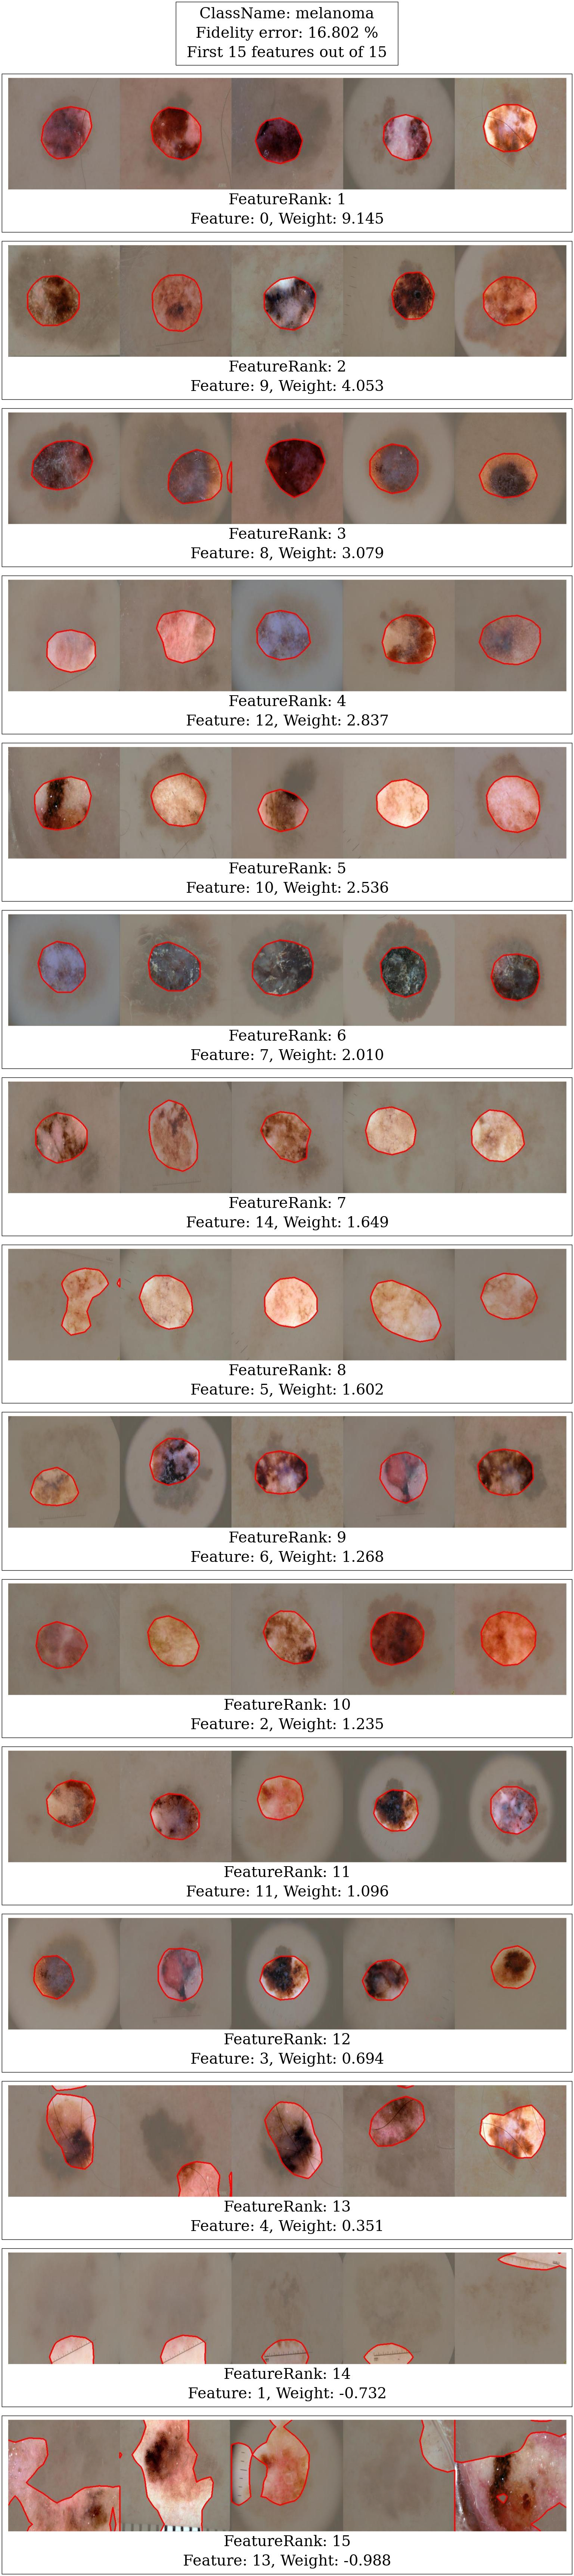

In [13]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 15
paras['layer_name'] = 'features'
paras['title'] = "melanoma_15_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

In [14]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 20
paras['layer_name'] = 'features'
paras['title'] = "melanoma_20_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

target_classes : [1]
classes_names : ['melanoma']
n_components : 20
layer_name : features
title : melanoma_20_concepts
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (78, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 17.371956825256348 s.
3/5 Error estimated, fidelity: [0.13737155].
4/5 Weight estimator initialized.
5/5 Weight estimated.
--r featuretopk 20
--r imgTopk 5
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
--r featureidx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
loading training data
batches 2


KeyboardInterrupt: 

In [ ]:
df.loc[((df['label']==1) & (df['Label_pred_iv4']==1) & (df['Label_pred_rn50']==1))]['image'].values[[56,52,30]]

In [ ]:
df.loc[((df['label']==1) & (df['Label_pred_iv4']==1) & (df['Label_pred_rn50']==1))]['image'].values


In [ ]:
np.array([[53, 58, 16, 64, 73, 71], [56, 52, 30], [29, 39, 31], [4, 21, 55]])[0][[1,5,2]]

In [ ]:
#img=Exp.features[0][0]
#img.shape

In [ ]:
#heatmap=Exp.features[0][1]

In [ ]:
#Exp.utils.show_img(X=img,nrows=1,ncols=1,heatmaps = heatmap,useColorBar = True, deprocessing = True, save_path = None)


In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [0]
paras['classes_names'] = ['benign']
paras['n_components'] = 10
paras['layer_name'] = 'features'
paras['title'] = "title"
paras['overwrite'] = True

for k,v in paras.items():
  print (k,':',v)

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=16,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))


In [ ]:
a=[1,2]

In [ ]:
a.extend([0,2])
a

In [ ]:
a+4

In [ ]:
for x in get_loaders([1])[0]:
    print(x)

In [ ]:
a=np.array(Exp.features[0][1])

In [ ]:
show_img(self,X,nrows=1,ncols=1,heatmaps = None,useColorBar = True, deprocessing = True, save_path = None):
    

In [ ]:
la=np.array([])
la

In [ ]:
for i in range(3):
    np.append(la,np.array([]))

In [ ]:
la

In [ ]:
np.reshape(la,([3,0]))

In [ ]:
la[2]

In [ ]:
a='ISIC_0015284.jpg'
a[:-4]